## Project - PyTorch for Deep Learning

##### First Name : 

##### Last Name : 

### Principles of PyTorch

PyTorch provides two main features:

- It enables tensor and vector computations on the GPU with an API similar to NumPy.
- It automatically records all computations to support backpropagation (or automatic differentiation). Given a sequence of operations from a tensor $\theta$ to define a scalar $g(\theta)$, it can compute $\nabla_\theta g(\theta)$ precisely (somehow ``exactly") with a single function call.

Typically, $\theta$ represents a neural network parameter, and $g$ is a loss function, such as $\ell(f_{\theta}(x), y)$ in supervised learning.

In PyTorch, each node in the computation graph is dynamically created during the forward pass within the Python interpreter, allowing easy transfer of NumPy code to PyTorch and preserving all flow control operations (e.g., loops, if/else statements).

### Setting up the device
PyTorch can run on either CPU or GPU as explained below:

In [81]:
import torch
torch.manual_seed(42)

# Two options: 'cuda' (for GPU) or 'cpu' (if no GPU available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Device type set:", "GPU" if device.type == "cuda" else "CPU")

Device type set: CPU


## PART I - A first example

Let us define the norm function $x→\|x\|$ on $\mathbb{R}^n$ using PyTorch. 

In [82]:
n = 3
x = torch.rand(n, dtype=torch.float32)
print(x)

tensor([0.8823, 0.9150, 0.3829])


Now define a norm function that returns the euclidean norm of a vector $x \in \mathbb{R}^n$:

$$f(x) = || x ||_2$$

In [ ]:
def f(x):
    return #TODO

In [84]:
f(x)

tensor(1.3275)

We are interested in computing $\nabla_x f(x) = \frac{x}{|| x ||_2}$.


### Exercise:

- Show rigorously that if $f(x) = || x ||_2$ then $\nabla_x f(x) = \frac{x}{|| x ||_2}$.


Assume we are too lazy to derive the analytical form of the gradient manually. Instead we will use the `autograd` facilities of PyTorch which is an implemented form of automatic differentiation (and backpropagation). Compare it with the expetected gradient $\frac{x}{|| x ||_2}$.

In [85]:
# TODO

### Exercise

- Write a function the pytorch code for function `g` that computes the cosine similarity of two variable vectors with float entries $\mathbf{x}$ and $\mathbf{y}$:

$$g(\mathbf{x}, \mathbf{y}) = \frac{\mathbf{x}^T \mathbf{y}}{|| \mathbf{x} ||_2 || \mathbf{y} ||_2 }$$

- Use `torch.autograd` to compute the derivatives with respect to $\mathbf{x} \in \mathbb{R}^3$ and $\mathbf{y} \in \mathbb{R}^3$ for some random values of your choice

- Compute $\nabla_x g(x, y)$ and $\nabla_y g(x, y)$ for some choice of $\mathbf{x} = \alpha \cdot \mathbf{y}$ with any $\alpha \in \mathbb{R}$. Check that you can get the expected result with Pytorch.

In [86]:
def g(x, y):
    # TODO: fix the following code to implement the cosine similarity function instead.
    return torch.sum(x) + torch.sum(y)


x = torch.tensor([0, 1, 2], dtype=torch.float32, requires_grad=True)
y = torch.tensor([3, 0.9, 2.2], dtype=torch.float32, requires_grad=True)

cosine = g(x, y)
cosine

tensor(9.1000, grad_fn=<AddBackward0>)

Let's reinitialize our two variables to non colinear values:

In [87]:
x = torch.tensor([0, 1, 2], dtype=torch.float32, requires_grad=True)
y = torch.tensor([3, 0.9, 2.2], dtype=torch.float32, requires_grad=True)

Execute the following cells many times (use `ctrl-enter`):

In [ ]:
cosine = g(x, y)
print('cosine:', cosine)
cosine.backward()
with torch.no_grad():
    # Do not record the following operations for future calls to cosine.backward().
    x.add_(0.5 * x.grad)
    y.add_(0.5 * y.grad)
print("x:", x)
print("y:", y)
print("x/y:", x / y)
print("x.grad:", x.grad)
print("y.grad:", y.grad)
x.grad.zero_()
y.grad.zero_();

cosine: tensor(9.1000, grad_fn=<AddBackward0>)
x: tensor([0.5000, 1.5000, 2.5000], requires_grad=True)
y: tensor([3.5000, 1.4000, 2.7000], requires_grad=True)
x/y: tensor([0.1429, 1.0714, 0.9259], grad_fn=<DivBackward0>)
x.grad: tensor([1., 1., 1.])
y.grad: tensor([1., 1., 1.])


What do you observe?

## PART II - Comparing gradient descent methods

In this part, we use PyTorch to compare the different gradient methods and a toy 2D examples: we will try to find the minimum of the difference of two Gaussians. PyTorch provides a convenient wrapper named `nn.Module` to define parametrized functions.

In [89]:
import torch.nn as nn
from torch.nn import Parameter

class Norm(nn.Module):

    def __init__(self, p=2.):
        super(Norm, self).__init__()
        self.p = Parameter(torch.tensor([p], dtype=torch.float32))

    def forward(self, x):
        p_sum = torch.sum(torch.pow(x, self.p), dim=0)
        return torch.pow(p_sum, 1 / self.p)

In the above definition, we treat the attribute `p` of the "p-norm" (a generalization of the euclidean norm) as a parameter that can be differentiated upon:

In [90]:
torch.manual_seed(42)

x = torch.rand(n)
norm = Norm(p=3.)
v = norm(x)
v.backward()

We can access $\nabla_p(x \to || x ||_p)$ in `norm.p.grad`

In [91]:
norm.p.grad

tensor([-0.1051])

We now define a Gaussian operator, along with a generic Gaussian combination. We will not consider the gradient w.r.t the parameters of these modules, hence we specify `requires_grad=False`

In [92]:
class Gaussian(nn.Module):

    def __init__(self, precision, mean):
        super(Gaussian, self).__init__()

        assert precision.shape == (2, 2)
        assert mean.shape == (2,)

        self.precision = Parameter(precision, requires_grad=False)
        self.mean = Parameter(mean, requires_grad=False)

    def forward(self, x):
        """Compute the (unormalized) likelihood of x given a Gaussian.

        x can be a 2D-vector or a batch of 2D-vectors.
        """
        xc = x - self.mean
        if len(xc.shape) == 1:
            # Reshape xc to work as a mini-batch of one vector.
            xc = xc.view(1, -1)
        return torch.exp(-.5 * (torch.sum((xc @ self.precision) * xc, dim=1)))


class GaussianCombination(nn.Module):

    def __init__(self, precisions, means, weights):
        super(GaussianCombination, self).__init__()
        assert len(precisions) == len(means) == len(weights)
        self.gaussians = nn.ModuleList()
        for precision, mean in zip(precisions, means):
            self.gaussians.append(Gaussian(precision, mean))
        self.weights = weights

    def forward(self, x):
        return sum(w * g(x) for g, w in zip(self.gaussians, self.weights))

We now define $f(x) = \exp(-(x- m_1)^T P_1 (x - m_1)) - \exp(-(x- m_2)^T P_2 (x - m_2))$

In [93]:
p1 = torch.tensor([[1, 0], [0, 4]], dtype=torch.float32)
m1 = torch.tensor([0, 1], dtype=torch.float)
w1 = 1
p2 = torch.tensor([[1, -2], [-2, 10]], dtype=torch.float32)
m2 = torch.tensor([0, -2], dtype=torch.float32)
w2 = -1

f = GaussianCombination([p1, p2], [m1, m2], [w1, w2])

We define a plotting function to visualize $f$. Note the small boilerplate to interface PyTorch with Numpy

In [94]:
import matplotlib.pyplot as plt
import numpy as np 

def plot_function(f, ax):
    x_max, y_max, x_min, y_min = 3, 3, -3, -3
    x = np.linspace(x_min, x_max, 100, dtype=np.float32)
    y = np.linspace(y_min, y_max, 100, dtype=np.float32)
    X, Y = np.meshgrid(x, y)
    samples = np.concatenate((X[:, :, None], Y[:, :, None]), axis=2)
    samples = samples.reshape(-1, 2)
    samples = torch.from_numpy(samples).requires_grad_()
    Z = f(samples).data.numpy()
    Z = Z.reshape(100, 100)
    CS = ax.contour(X, Y, Z)
    ax.clabel(CS, inline=1, fontsize=10)

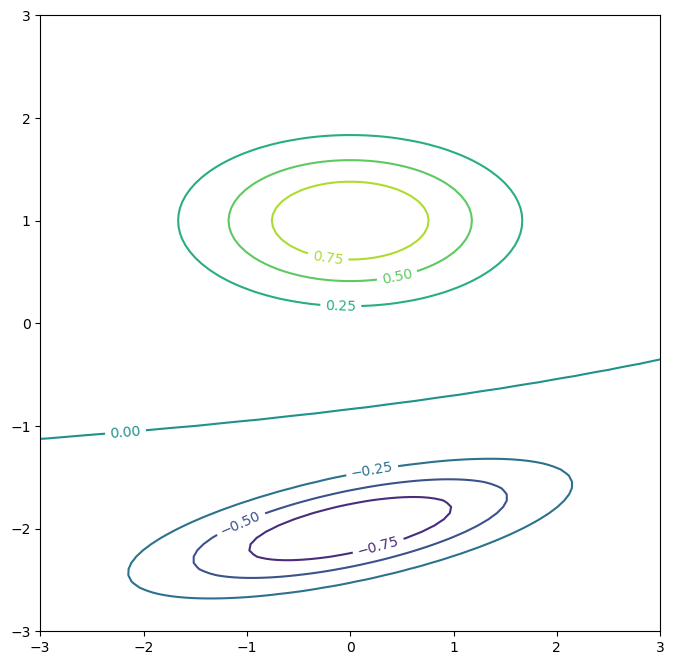

In [95]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_function(f, ax)

We will now try to minimize $f$ using gradient descent (including optional features). For this, we define a minimize function that performs gradient descent, along with a helper class `GradientDescent` that will perform the updates given the gradient

In [96]:
class GradientDescent:

    def __init__(self, params, lr=0.1):
        self.params = params
        self.lr = lr

    def step(self):
        with torch.no_grad():
            for param in self.params:
                param -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

In [129]:
def minimize(f, optimizer, max_iter=10000, verbose=False):
    if hasattr(optimizer, 'params'):
        [iterate] = optimizer.params
    else:
        # For pytorch optimizers.
        assert len(optimizer.param_groups) == 1
        [iterate] = optimizer.param_groups[0]['params']
    iterate_record = []

    for i in range(max_iter):
        # iterate.grad may be non zero. We zero it first:
        optimizer.zero_grad()
        value = f(iterate)

        # Compute the gradient of f with respect to the parameters:
        value.backward()
        # iterate.grad now holds $\nabla_x f(x)$
        if float(torch.sum(iterate.grad ** 2)) < 1e-6:
            if verbose:
                print('Converged at iteration %i: '
                      'f(x) = %e, x = [%e, %e]'
                      % (i, value, iterate[0], iterate[1]))
            break

        # We store the trajectory of the iterates
        iterate_record.append(iterate.data.clone()[None, :])
        if verbose and i % 100 == 0:
            print('Iteration %i: f(x) = %e, x = [%e, %e]'
                  % (i, value, iterate[0], iterate[1]))

        # Perform the parameter update step using the gradient
        # values:
        optimizer.step()
    return torch.cat(iterate_record, dim=0)

Run the minimization algorithm and plot it:

In [130]:
# The extra dimension marked with `None` is used to make it
# possible
init = torch.tensor([0.8, 0.8], dtype=torch.float32)
optimizer = GradientDescent([init.clone().requires_grad_()], lr=0.01)
iterate_rec = minimize(f, optimizer, verbose=True)

Iteration 0: f(x) = 6.703200e-01, x = [8.000000e-01, 8.000000e-01]
Iteration 100: f(x) = 1.308716e-01, x = [1.144553e+00, 1.697777e-01]
Iteration 200: f(x) = 4.009142e-02, x = [1.230556e+00, -1.089270e-01]
Iteration 300: f(x) = 2.041423e-02, x = [1.266157e+00, -2.428946e-01]
Iteration 400: f(x) = 1.291606e-02, x = [1.286912e+00, -3.264865e-01]
Iteration 500: f(x) = 9.127466e-03, x = [1.301103e+00, -3.862050e-01]
Iteration 600: f(x) = 6.861006e-03, x = [1.311735e+00, -4.325364e-01]
Iteration 700: f(x) = 5.335258e-03, x = [1.320195e+00, -4.706378e-01]
Iteration 800: f(x) = 4.208297e-03, x = [1.327232e+00, -5.034490e-01]
Iteration 900: f(x) = 3.306572e-03, x = [1.333299e+00, -5.328546e-01]
Iteration 1000: f(x) = 2.529371e-03, x = [1.338695e+00, -5.602059e-01]
Iteration 1100: f(x) = 1.808241e-03, x = [1.343639e+00, -5.866014e-01]
Iteration 1200: f(x) = 1.085154e-03, x = [1.348312e+00, -6.130803e-01]
Iteration 1300: f(x) = 2.945241e-04, x = [1.352887e+00, -6.408132e-01]
Iteration 1400: f(x)

In [124]:
def plot_trace(iterate_rec, ax, label='', tags=True):
    iterate_rec = iterate_rec.numpy()
    n_steps = len(iterate_rec)
    line = ax.plot(iterate_rec[:, 0], iterate_rec[:, 1], linestyle=':',
                   marker='o', markersize=2,
                   label=label + " (%d steps)" % n_steps)
    color = plt.getp(line[0], 'color')
    bbox_props = dict(boxstyle="square,pad=0.3", ec=color, fc='white',
                      lw=1)
    if tags:
        # Put tags every 10 iterates. The small randomization makes it
        # easier to spot tag overlap when the steps are very small.
        for i in range(0, len(iterate_rec), 10):
            ax.annotate(i, xy=(iterate_rec[i, 0], iterate_rec[i, 1]),
                        xycoords='data',
                        xytext=(5 + np.random.uniform(-2, 2),
                                5 + np.random.uniform(-2, 2)),
                        textcoords='offset points',
                        bbox=bbox_props)

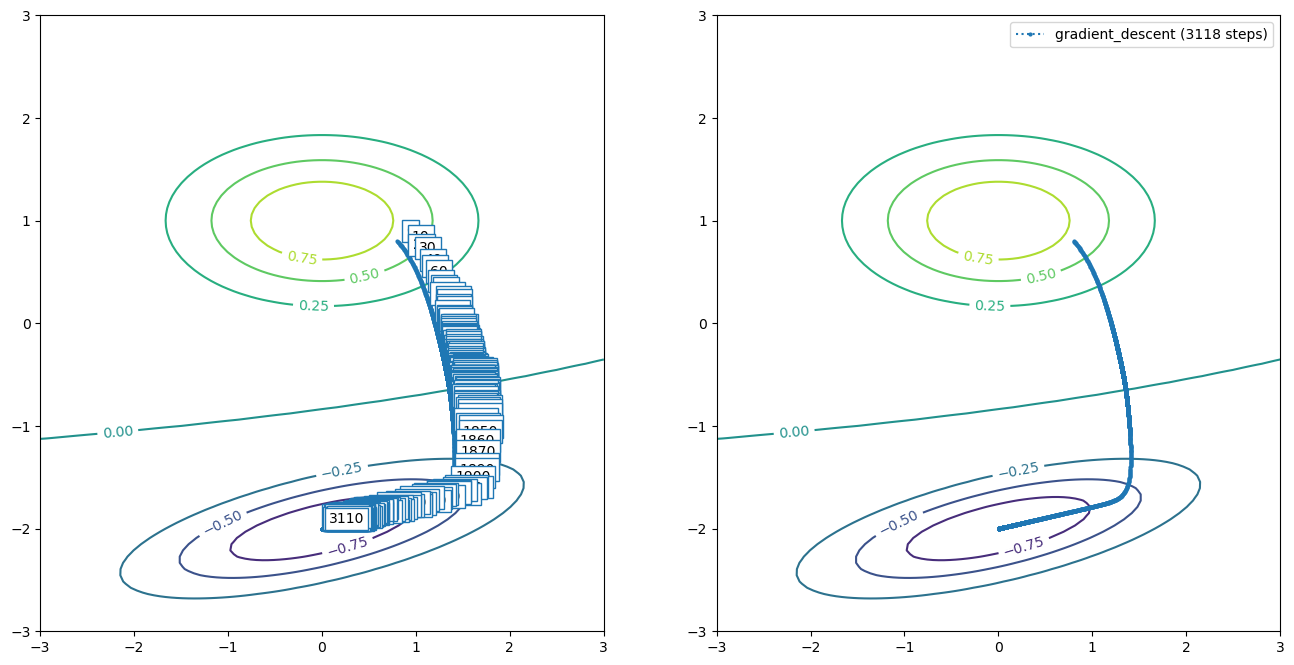

In [125]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
plot_function(f, ax1)
plot_function(f, ax2)
plot_trace(iterate_rec, ax1, label='gradient_descent')
plot_trace(iterate_rec, ax2, label='gradient_descent', tags=False)
plt.legend();

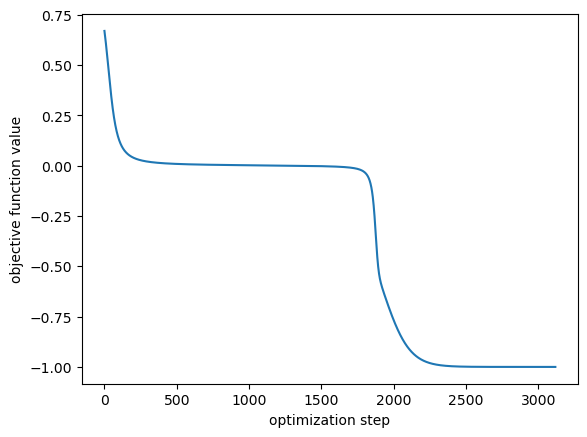

In [126]:
plt.plot([f(x).numpy() for x in iterate_rec])
plt.xlabel('optimization step')
plt.ylabel('objective function value');

### Exercices

- Try to move the initialization point to the other side of the yellow mountain, for instance at position `[0.8, 1.2]`. What do you observe? How to do you explain this?

- Put back the init to `[0.8, 0.8]` and implement the step method of `MomemtumGradientDescent` in the following cell,
- Check that it behaves as `GradientDescent` for `momemtum=0`
- Can you find a value of `momentum` that makes it converge faster than gradient descent on for this objective function? Try with different values of `lr` and `momentum`.
- Add [torch.optim.Adam](http://pytorch.org/docs/main/generated/torch.optim.Adam.html#torch.optim.Adam) and [torch.optim.RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html) in the minimization loop.
- Compare the four trajectories.


For the momentum let's use the following 2-stage mathematical description of the update step:

$$ \mathbf{v} \leftarrow \mu \cdot \mathbf{v} + \nabla_\mathbf{x}\ell(\mathbf{x}) $$
$$ \mathbf{x} \leftarrow \eta \cdot \mathbf{v} $$

where:

- $\eta$ is the learning rate coefficient (`lr` in Python code);
- $\mu$ is the momentum coefficient (set to 0.9 by default);
- $\nabla_\mathbf{x}\ell(\mathbf{x})$ is the gradient of the loss function for the current value of the parameters $\mathbf{x}$;
- $\mathbf{v}$ is the tensor of velocities and as the same shape as the parameters tensor $\theta$. $v$ is initialized to zero.

In [127]:
class MomentumGradientDescent(GradientDescent):

    def __init__(self, params, lr=0.1, momentum=.9):
        super(MomentumGradientDescent, self).__init__(params, lr)
        self.momentum = momentum
        self.velocities = [torch.zeros_like(param, requires_grad=False)
                           for param in params]

    def step(self):
        # TODO: implement me!
        pass

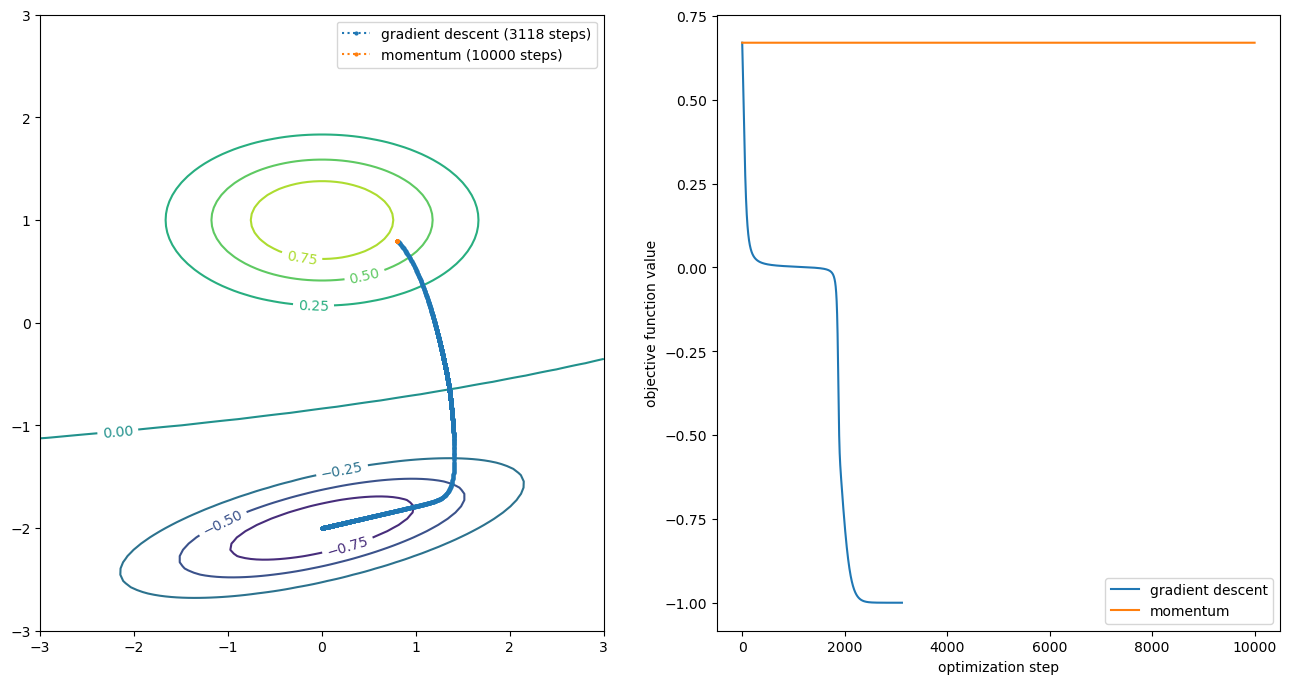

In [128]:
lr = 0.01
init = torch.FloatTensor([0.8, 0.8])

# Gradient Descent
optimizer = GradientDescent([init.clone().requires_grad_()], lr=lr)
iterate_rec_gd = minimize(f, optimizer)

# Momentum
optimizer = MomentumGradientDescent([init.clone().requires_grad_()],
                                    lr=lr, momentum=0.0)
iterate_rec_mom = minimize(f, optimizer)


#optimizer_adam = # TODO
#iterate_rec_adam = minimize(f, optimizer_adam)


#optimizer_rmsprop = # TODO
#iterate_rec_rmsprop = minimize(f, optimizer_rmsprop)

# Plotting
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16, 8))

# Plot the function and the optimization paths
plot_function(f, ax0)
plot_trace(iterate_rec_gd, ax0, label='gradient descent', tags=False)
plot_trace(iterate_rec_mom, ax0, label='momentum', tags=False)
#plot_trace(iterate_rec_adam, ax0, label='adam', tags=False)
#plot_trace(iterate_rec_rmsprop, ax0, label='rmsprop', tags=False)
ax0.legend()

# Plot the objective function value over optimization steps
ax1.plot([f(x).item() for x in iterate_rec_gd], label='gradient descent')
ax1.plot([f(x).item() for x in iterate_rec_mom], label='momentum')
#ax1.plot([f(x).item() for x in iterate_rec_adam], label='adam')
#ax1.plot([f(x).item() for x in iterate_rec_rmsprop], label='rmsprop')
ax1.set_xlabel('optimization step')
ax1.set_ylabel('objective function value')
ax1.legend()

What do you observe ? Try changing the momentum and the initialization to compare optimization traces.

## PART III - Fashion MNIST classification using PyTorch

In this part, we will try to classify the Fashion MNIST dataset
(https://github.com/zalandoresearch/fashion-mnist) using VGG-like architectures (https://arxiv.org/abs/1409.1556). This part is inspired from the MNIST example from PyTorch (https://github.com/pytorch/examples/tree/master/mnist), and introduce tricks to automatically tune and schedule the learning rate for SGD (see this course's slides, https://arxiv.org/abs/1506.01186, and FastAI course for example http://fastai.org).

## Fashion MNIST

This 10 class dataset is a drop-in replacement for MNIST with clothes instead of digits.

<img src="https://api.wandb.ai/files/kylegtest/fashion-mnist-gan/up6zul3y/media/images/Generator%20Output_1396.png?height=55" alt="fashion_mnist" height="300px">

Let's import a few functions first

In [105]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib.cm import get_cmap
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets
from torchvision.transforms import transforms

Some system/model hyper parameters

In [106]:
cuda = False
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

In [157]:
english_labels = [
                  "Trouser",
                  "T-shirt/top",
                  "Pullover",
                  "Dress",
                  "Coat",
                  "Sandal",
                  "Shirt",
                  "Sneaker",
                  "Bag",
                  "Ankle boot"]

train_data = datasets.FashionMNIST('data', train=True, download=True,
                                   transform=transforms.Compose([
                                       transforms.ToTensor(),
                                   ]))
train_loader = DataLoader(train_data, batch_size=128, shuffle=False, **kwargs)

Let's compute the average mean and std of the train images. We will use them for normalizing data later on.

In [108]:
n_samples_seen = 0.
mean = 0
std = 0
for train_batch, train_target in train_loader:
    batch_size = train_batch.shape[0]
    train_batch = train_batch.view(batch_size, -1)
    this_mean = torch.mean(train_batch, dim=1)
    this_std = torch.sqrt(
        torch.mean((train_batch - this_mean[:, None]) ** 2, dim=1))
    mean += torch.sum(this_mean, dim=0)
    std += torch.sum(this_std, dim=0)
    n_samples_seen += batch_size

mean /= n_samples_seen
std /= n_samples_seen

In [131]:
print(mean, std)

tensor(0.2860) tensor(0.3202)


We now reload the data with a further `Normalize` transform.

In [138]:
train_data = datasets.FashionMNIST('data', train=True, download=False,
                                   transform=transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=mean.view(1),
                                                            std=std.view(1))]))

test_data = datasets.FashionMNIST('data', train=False, download=True,
                                  transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=mean.view(1),
                                                           std=std.view(1))]))

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=32,
                                          shuffle=False, **kwargs)


We define a very simple model, suitable for CPU training.

In [139]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=(3, 3), padding=1)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=(3, 3), padding=1)
        self.dropout_2d = nn.Dropout2d(p=0.25)
        self.fc1 = nn.Linear(7 * 7 * 20, 128)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.dropout_2d(F.max_pool2d(self.conv1(x), kernel_size=2))
        x = self.dropout_2d(F.max_pool2d(self.conv2(x), kernel_size=2))
        x = x.view(-1, 7 * 7 * 20)  # flatten / reshape
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()
        self.fc1.reset_parameters()
        self.fc2.reset_parameters()

In [141]:
train_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=tensor([0.2860]), std=tensor([0.3202]))
           )

We can plot a training image.

In [158]:
model = Model()
img, target = train_data[1]
# n_channel, width, height
print(img.shape)

torch.Size([1, 28, 28])


/var/folders/5t/vn7jb6rx2874dqk3khxl4j540000gn/T/ipykernel_80009/599630494.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax.imshow(img[0].numpy(), cmap=get_cmap('gray'))


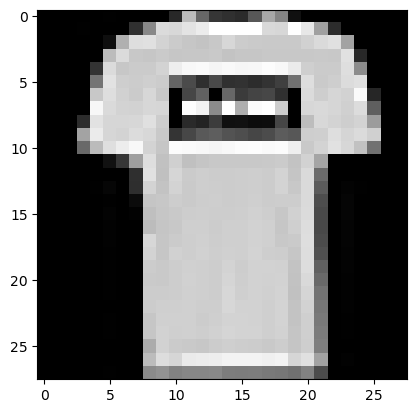

In [159]:
fig, ax = plt.subplots(1, 1)
ax.imshow(img[0].numpy(), cmap=get_cmap('gray'))
plt.show()

In [160]:
pred = model(img[None, :])
print(target, english_labels[target])
print(pred)

0 Trouser
tensor([[-2.2347, -2.3231, -2.3131, -2.3083, -2.3082, -2.2914, -2.2612, -2.3083,
         -2.3484, -2.3343]], grad_fn=<LogSoftmaxBackward0>)


We define a train loop and a test function.

In [162]:
def train(model, optimizer, train_loader, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        batch_size = data.shape[0]
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * batch_size

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch + 1, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    train_loss /= len(test_loader.dataset)
    return train_loss

def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            if cuda:
                data, target = data.cuda(), target.cuda()
            output = model(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # sum up batch loss
            _, pred = output.data.max(dim=1)
            # get the index of the max log-probability
            correct += torch.sum(pred == target.data.long()).item()

        test_loss /= len(test_loader.dataset)
        test_accuracy = float(correct) / len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f},'
              ' Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * test_accuracy))
    return test_loss, test_accuracy

The `find_lr` function provides a learning rate for SGD or Adam, following heuristics from https://arxiv.org/abs/1506.01186:

In [163]:
import numpy as np

def loop_loader(data_loader):
    while True:
        for elem in data_loader:
            yield elem

def find_lr(model, train_loader, init_lr, max_lr, steps, n_batch_per_step=30):
    optimizer = torch.optim.SGD(model.parameters(), lr=init_lr)
    current_lr = init_lr
    best_lr = current_lr
    best_loss = float('inf')
    lr_step = (max_lr - init_lr) / steps

    loader = loop_loader(train_loader)
    for i in range(steps):
        mean_loss = 0
        n_seen_samples = 0
        for j, (data, target) in enumerate(loader):
            if j > n_batch_per_step:
                break
            optimizer.zero_grad()
            if cuda:
                data = data.cuda()
                target = target.cuda()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            mean_loss += loss.item() * data.shape[0]
            n_seen_samples += data.shape[0]
            optimizer.step()

        mean_loss /= n_seen_samples
        print('Step %i, current LR: %f, loss %f' % (i, current_lr, mean_loss))
            
        if np.isnan(mean_loss) or mean_loss > best_loss * 4:
            return best_lr / 4
        
        if mean_loss < best_loss:
            best_loss = mean_loss
            best_lr = current_lr

        current_lr += lr_step
        optimizer.param_groups[0]['lr'] = current_lr

    return best_lr / 4

Let's load our model on the GPU if required. We then define an optimizer and a learning rate scheduler. (It takes 4mn to run with CPU Macbook PRO M1). 

In [164]:
log_interval = 100
epochs = 12

if cuda:
    model.cuda()

model.reset_parameters()
lr = find_lr(model, train_loader, 1e-4, 1, 100, 30)
model.reset_parameters()

print('Best LR', lr)

Step 0, current LR: 0.000100, loss 2.303451
Step 1, current LR: 0.010099, loss 2.303311
Step 2, current LR: 0.020098, loss 2.303095
Step 3, current LR: 0.030097, loss 2.303078
Step 4, current LR: 0.040096, loss 2.302986
Step 5, current LR: 0.050095, loss 2.302527
Step 6, current LR: 0.060094, loss 2.302500
Step 7, current LR: 0.070093, loss 2.302441
Step 8, current LR: 0.080092, loss 2.302235
Step 9, current LR: 0.090091, loss 2.300422
Step 10, current LR: 0.100090, loss 2.219276
Step 11, current LR: 0.110089, loss 2.097854
Step 12, current LR: 0.120088, loss nan
Best LR 0.027522250000000012


Let's train our model. 

**NB:** If training a large model is slow on your local computer, try using Google Colab with GPU support.

In [165]:
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                       T_max=3,
                                                       last_epoch=-1)

logs = {'epoch': [], 'train_loss': [], 'test_loss': [],
        'test_accuracy': [], 'lr': []}

In [ ]:
for epoch in range(epochs):
    train_loss = train(model, optimizer, train_loader, epoch)
    test_loss, test_accuracy = test(model, test_loader)
    logs['epoch'].append(epoch)
    logs['train_loss'].append(train_loss)
    logs['test_loss'].append(test_loss)
    logs['test_accuracy'].append(test_accuracy)
    logs['lr'].append(optimizer.param_groups[0]['lr'])
    scheduler.step(epoch)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.300432
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.303388
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.306124
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.301473
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.301835


/Users/ryanboustany/anaconda3/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 2.2969, Accuracy: 1580/10000 (16%)



/Users/ryanboustany/anaconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 2 [0/60000 (0%)]	Loss: 2.300954
Train Epoch: 2 [12800/60000 (21%)]	Loss: 2.285926
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.024804
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.736022
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.815646

Test set: Average loss: 1.5360, Accuracy: 7274/10000 (73%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.635645
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.534632
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.536788
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.567255
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.589429


### Exercices

- Define a VGG-like model: add more convolutional and max pooling layers to increase the number of channels progressively while decreasing the dimensions of the feature maps with max pooling.
- Research and briefly explain what dropout is.
- Try to use Adam instead of SGD in conjunction with the `find_lr` heuristic and the cosine learning rate schedule above;
- Try to beat the test accuracy of the model ``class Model(nn.Module):`` above ( $\approx$ 90 %).
- (optional) Try data augmentation (horizontal flips, random crops, cutout...);
- (optional) Try to use batch-normalization;
- (optional) Implement the [mixup stochastic label interpolation](https://arxiv.org/abs/1710.09412);
- (optional) Implement skip-connections.

See how you compare to other approaches:
- https://github.com/zalandoresearch/fashion-mnist
- https://www.kaggle.com/zalando-research/fashionmnist

**NB:** If training a large model is slow on your local computer, try using Google Colab with GPU support.

In [ ]:
class VGGCell(nn.Module):
    def __init__(self, in_channel, out_channel, depth, max_pooling=True):
        super(VGGCell, self).__init__()
        self.convs = nn.ModuleList()
        for i in range(depth):
            if i == 0:
                self.convs.append(nn.Conv2d(in_channel, out_channel,
                                            kernel_size=(3, 3),
                                            padding=1))
            else:
                self.convs.append(nn.Conv2d(out_channel, out_channel,
                                            kernel_size=(3, 3),
                                            padding=1))
        self.max_pooling = max_pooling

    def forward(self, x):
        for conv in self.convs:
            x = conv(x)
        if self.max_pooling:
            x = ##TODO
        return x

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()


class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        vgg1 = VGGCell(1, 32, 2, max_pooling=True)
        vgg2 = VGGCell(32, 64, 3, max_pooling=False)
        vgg3 = VGGCell(64, 128, 3, max_pooling=True)
        vgg4 = VGGCell(128, 256, 3, max_pooling=False)
        self.vggs = nn.ModuleList([vgg1, vgg2, vgg3, vgg4])
        self.dropout_2d = nn.Dropout2d(p=0.25)
        self.fc1 = nn.Linear(7 * 7 * 256, 256)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        for vgg in self.vggs:
            x = self.dropout_2d(vgg(x))
        x = x.view(-1, 7 * 7 * 256)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = ##TODO
        return ##TODO

    def reset_parameters(self):
        for vgg in self.vggs:
            vgg.reset_parameters()
        self.fc1.reset_parameters()
        self.fc2.reset_parameters()

## PART IV 

Summarize what you have learned from this project and the course in general. Describe the skills you have gained and what you are now able to accomplish with PyTorch.

#TODO